# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
from collections import defaultdict
import re

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools

In [3]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [4]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [5]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
FREQ=60
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [6]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [76]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [7]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [8]:
all_session_dir = ['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

In [9]:
all_session_dir

['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [10]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [11]:
CHANNEL_MAPPING_DF

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0
5,2,1.2,NaN,31,30,29,28,10.0,31.0,30.0,29.0,28.0
6,2,1.3,NaN,15,14,13,12,9.0,31.0,30.0,29.0,28.0
7,2,1.4,NaN,15,14,13,12,15.0,31.0,30.0,29.0,28.0


### Getting the subject IDs from the file name

In [12]:
TONE_TIMESTAMP_DF = pd.read_pickle("./proc/melted_trials_and_video.pkl")


In [13]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [14]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [15]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [16]:
all_trials_df["recording_dir"].unique()

array(['20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [17]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [18]:
all_trials_df["all_subjects"].head()

0    [1.4, 1.1]
1    [1.4, 1.1]
2    [1.4, 1.1]
3    [1.4, 1.1]
4    [1.4, 1.1]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [19]:
all_trials_df["subject_info"].head()

0    1_1_t1b2L_box2
1    1_1_t1b2L_box2
2    1_1_t1b2L_box2
3    1_1_t1b2L_box2
4    1_1_t1b2L_box2
Name: subject_info, dtype: object

In [20]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [21]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [22]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [23]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


### Extracting the LFP

In [25]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in all_session_dir:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            # Preprocessing the LFP
            current_recording = sp.bandpass_filter(current_recording, freq_min=0.5, freq_max=300)
            current_recording = sp.notch_filter(current_recording, freq=60)
            current_recording = sp.resample(current_recording, resample_rate=1000)
            current_recording = sp.zscore(current_recording)
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except:
            pass



20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
20221215_145401_comp_amd_om_6_1_top_4_base_3
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged


- Filtering for all trials that have labels

In [26]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_all_ch_lfp.keys())].reset_index(drop=True)

In [27]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


In [28]:
all_trials_df["trial_outcome"].unique()

array(['lose', 'win', 'rewarded', 'omission'], dtype=object)

In [29]:
all_trials_df["trial_or_baseline"].unique()

array(['baseline', 'trial'], dtype=object)

In [30]:
recording_name_to_all_ch_lfp.keys()

dict_keys(['20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged', '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', '20221215_145401_comp_amd_om_6_1_top_4_base_3', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged'])

In [31]:
CHANNEL_MAPPING_DF

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0
5,2,1.2,NaN,31,30,29,28,10.0,31.0,30.0,29.0,28.0
6,2,1.3,NaN,15,14,13,12,9.0,31.0,30.0,29.0,28.0
7,2,1.4,NaN,15,14,13,12,15.0,31.0,30.0,29.0,28.0


## Power Calculation

In [32]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


- Adding all the brain region to ch information

In [33]:
channel_map_and_all_trials_df = all_trials_df.merge(CHANNEL_MAPPING_DF, left_on="current_subject", right_on="Subject", how="left")

- Linking up all LFP calculations with all the trials

In [34]:
channel_map_and_all_trials_df["all_ch_lfp"] = channel_map_and_all_trials_df["recording_file"].map(recording_name_to_all_ch_lfp)

- Creating a new row for each brain region

In [35]:
brain_region_col = [col for col in CHANNEL_MAPPING_DF if "spike_interface" in col]

In [36]:
id_cols = [col for col in channel_map_and_all_trials_df.columns if col not in brain_region_col]

In [37]:
melted_channel_map_and_all_trials_df = channel_map_and_all_trials_df.melt(id_vars=id_cols ,value_vars=brain_region_col, var_name='brain_region', value_name='channel')


In [38]:
melted_channel_map_and_all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,all_ch_lfp,brain_region,channel
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0


In [39]:
melted_channel_map_and_all_trials_df.tail()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,all_ch_lfp,brain_region,channel
1515,66660918,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,64158037,20230620_114347_standard_comp_to_omission_D4_s...,64089,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
1516,68560944,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,66058063,20230620_114347_standard_comp_to_omission_D4_s...,65986,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
1517,68560944,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,66058063,20230620_114347_standard_comp_to_omission_D4_s...,65986,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
1518,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0


- Getting the traces for each trial for each brain region

In [40]:
melted_channel_map_and_all_trials_df["channel"] = melted_channel_map_and_all_trials_df["channel"].astype(int).astype(str)
melted_channel_map_and_all_trials_df["resampled_index"] = melted_channel_map_and_all_trials_df["resampled_index"].astype(int)

In [41]:
melted_channel_map_and_all_trials_df["chunked_lfp_index"].iloc[0]

[(44962, 45962),
 (45962, 46962),
 (46962, 47962),
 (47962, 48962),
 (48962, 49962),
 (49962, 50962),
 (50962, 51962),
 (51962, 52962),
 (52962, 53962),
 (53962, 54962)]

In [42]:
melted_channel_map_and_all_trials_df["binned_current_thorax_velocity"].iloc[0]

[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]

In [43]:
melted_channel_map_and_all_trials_df["chunked_current_trace"] = melted_channel_map_and_all_trials_df.apply(lambda x: 
[x["all_ch_lfp"].get_traces(channel_ids=[x["channel"]], start_frame=chunk_index[0], end_frame=chunk_index[1]).T[0] for chunk_index in x["chunked_lfp_index"]], axis=1)

In [44]:
len(melted_channel_map_and_all_trials_df["chunked_current_trace"].iloc[0])

10

In [45]:
melted_channel_map_and_all_trials_df["chunked_current_trace"]

0       [[1.2846744, 1.113752, 0.7553665, 0.60466075, ...
1       [[0.36573705, 0.3547098, 0.32162806, 0.2554645...
2       [[-0.4557929, -0.48152316, -0.32897955, -0.194...
3       [[0.7608801, 0.7094196, 0.8435845, 1.0071553, ...
4       [[0.077190734, -0.19849047, -0.40065667, -0.56...
                              ...                        
1515    [[-0.6621465, -0.55837727, -0.3681337, -0.2866...
1516    [[0.9363938, 1.0475751, 1.2649963, 1.3069981, ...
1517    [[-0.044472527, -0.30142492, -0.8029762, -1.23...
1518    [[1.2155824, 0.6102619, -0.022236263, -0.38048...
1519    [[1.0451044, 0.62508607, 0.21247986, 0.4447252...
Name: chunked_current_trace, Length: 1520, dtype: object

In [46]:
exploded_channel_map_and_all_trials_df = melted_channel_map_and_all_trials_df.explode(["current_chunked_thorax_velocity", "chunked_current_trace", "binned_current_thorax_velocity", "chunked_lfp_index",	"chunked_ephys_timestamp"])

In [47]:
exploded_channel_map_and_all_trials_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,all_ch_lfp,brain_region,channel,chunked_current_trace
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[1.2846744, 1.113752, 0.7553665, 0.60466075, 0..."
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[1.4776512, 1.4813269, 1.3287834, 1.1174278, 1..."
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[-0.88034195, -0.4502793, 0.033081744, -0.1249..."
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[0.093731605, -0.05513624, -0.24443734, -0.317..."
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[-0.40249455, -0.51092917, -0.46314442, -0.382..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-1.1488736, -0.8647436, -0.6843828, -0.723913..."
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-1.1068718, -0.6769707, -0.71650183, -0.95121..."
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-0.5336703, -0.39284065, -0.6769707, -0.69920..."
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-1.8653754, -1.6306593, -1.7863132, -1.761606..."


In [48]:
exploded_channel_map_and_all_trials_df["len_chunked_current_trace"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: len(x))


In [49]:
exploded_channel_map_and_all_trials_df["len_chunked_current_trace"].unique()

array([1000, 1001])

In [50]:
exploded_channel_map_and_all_trials_df["chunked_current_trace"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: x[:RESAMPLE_RATE])

In [51]:
exploded_channel_map_and_all_trials_df["chunked_current_trace"]

0       [1.2846744, 1.113752, 0.7553665, 0.60466075, 0...
0       [1.4776512, 1.4813269, 1.3287834, 1.1174278, 1...
0       [-0.88034195, -0.4502793, 0.033081744, -0.1249...
0       [0.093731605, -0.05513624, -0.24443734, -0.317...
0       [-0.40249455, -0.51092917, -0.46314442, -0.382...
                              ...                        
1519    [-1.1488736, -0.8647436, -0.6843828, -0.723913...
1519    [-1.1068718, -0.6769707, -0.71650183, -0.95121...
1519    [-0.5336703, -0.39284065, -0.6769707, -0.69920...
1519    [-1.8653754, -1.6306593, -1.7863132, -1.761606...
1519    [-2.5719945, -2.7202363, -2.5868187, -2.315042...
Name: chunked_current_trace, Length: 15200, dtype: object

- Calcuating the power at each frequency band

In [52]:
exploded_channel_map_and_all_trials_df["multitaper"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: Multitaper(time_series=x,                                                                                        sampling_frequency=RESAMPLE_RATE))

In [53]:
exploded_channel_map_and_all_trials_df["connectivity"] = exploded_channel_map_and_all_trials_df["multitaper"].apply(lambda x: Connectivity.from_multitaper(x))

In [54]:
exploded_channel_map_and_all_trials_df["frequencies"] = exploded_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.frequencies)

In [55]:
exploded_channel_map_and_all_trials_df["power"] = exploded_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.power().squeeze())

In [56]:
exploded_channel_map_and_all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,eib_MD,all_ch_lfp,brain_region,channel,chunked_current_trace,len_chunked_current_trace,multitaper,connectivity,frequencies,power
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[1.2846744, 1.113752, 0.7553665, 0.60466075, 0...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.02309027537108904, 0.03376274381096272, 0.0..."
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[1.4776512, 1.4813269, 1.3287834, 1.1174278, 1...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.02037680255662344, 0.02703298332514505, 0.0..."
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[-0.88034195, -0.4502793, 0.033081744, -0.1249...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.06475578281033083, 0.04809674891904778, 0.0..."
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[0.093731605, -0.05513624, -0.24443734, -0.317...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.024690271716308453, 0.024697344579884397, 0..."
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5,"[-0.40249455, -0.51092917, -0.46314442, -0.382...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.03691878756910202, 0.04017695307697495, 0.0..."


In [57]:
exploded_channel_map_and_all_trials_df.tail()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,eib_MD,all_ch_lfp,brain_region,channel,chunked_current_trace,len_chunked_current_trace,multitaper,connectivity,frequencies,power
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-1.1488736, -0.8647436, -0.6843828, -0.723913...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.013680018536030993, 0.016120789089095096, 0..."
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-1.1068718, -0.6769707, -0.71650183, -0.95121...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.009893458358479365, 0.027273889590957303, 0..."
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-0.5336703, -0.39284065, -0.6769707, -0.69920...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.010763733253780869, 0.011373811194488024, 0..."
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-1.8653754, -1.6306593, -1.7863132, -1.761606...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.010225214552242224, 0.012050439402122547, 0..."
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-2.5719945, -2.7202363, -2.5868187, -2.315042...",1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.03049284796344417, 0.03226316474763924, 0.0..."


# Plotting by velocity

In [77]:
raise ValueError()

ValueError: 

- Grouping all the rows(1s segment of trials) that share the same brain region, whether its before or after the tone, and velocity grouping

In [78]:
grouped_all_trials_df = exploded_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_or_baseline', 'binned_current_thorax_velocity']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

- Calculating the mean and sem of the LFP power

In [79]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [80]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [81]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [82]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

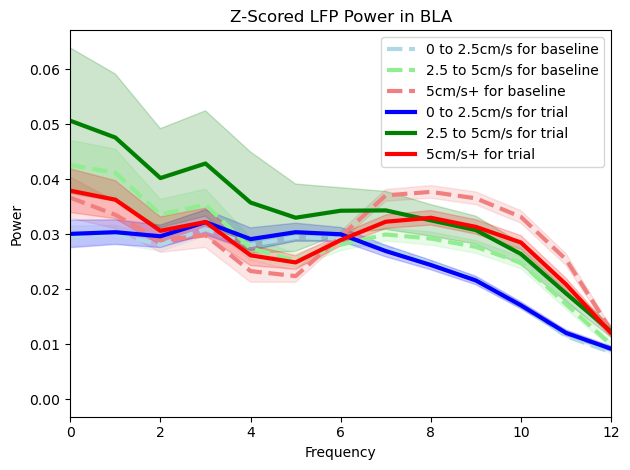

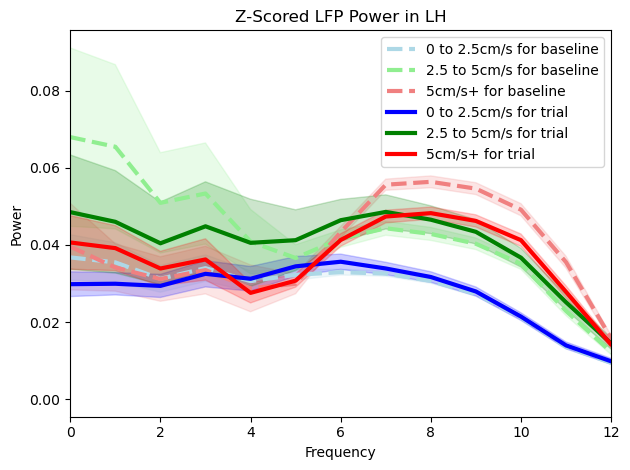

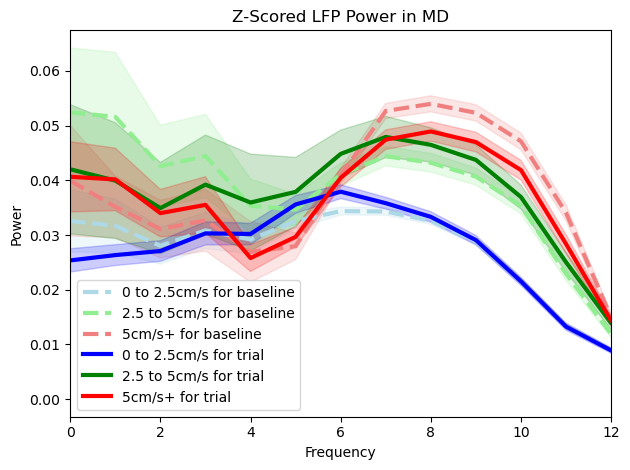

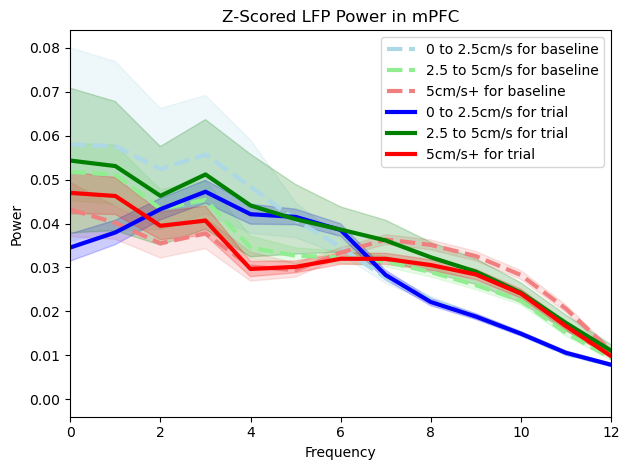

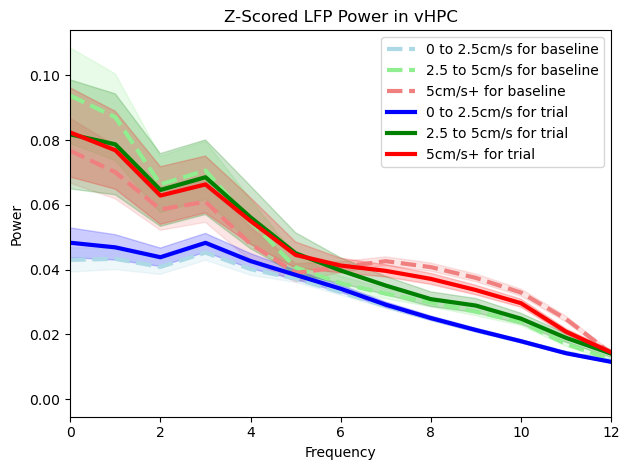

In [87]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(bin_to_velocity[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue
    ax.legend()
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsing/region_baselinetrial_velocity/z_scored_lfp_power_freq_{}_to_{}_region_{}.png"\
    .format(low_freq, high_freq, region.split("_")[-1]))


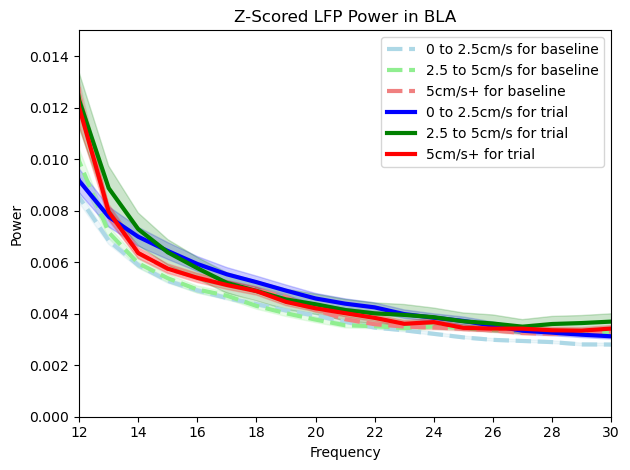

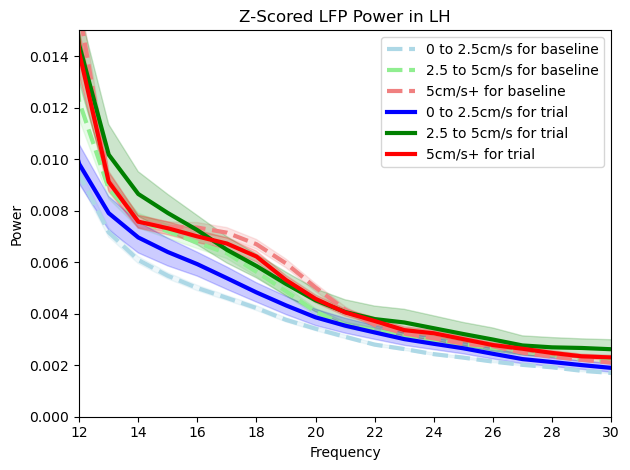

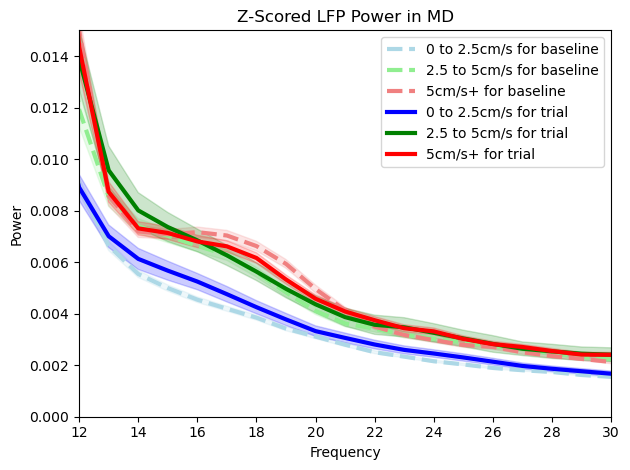

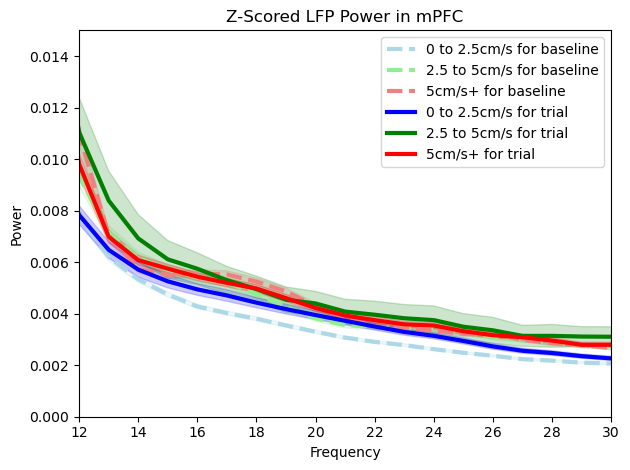

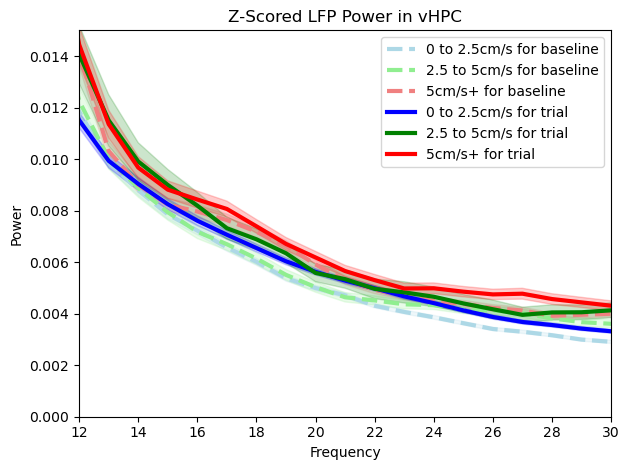

In [88]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.ylim(0, 0.015)

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(bin_to_velocity[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue
    ax.legend()
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsing/region_baselinetrial_velocity/z_scored_lfp_power_freq_{}_to_{}_region_{}.png"\
    .format(low_freq, high_freq, region.split("_")[-1]))


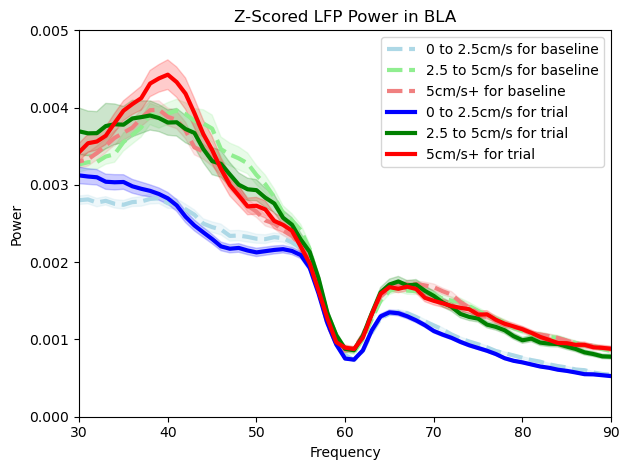

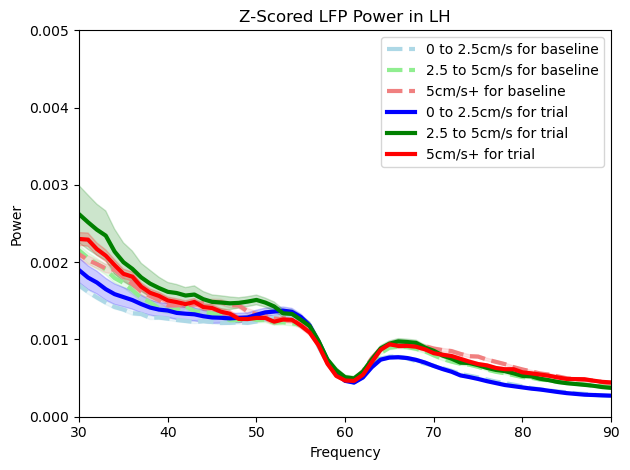

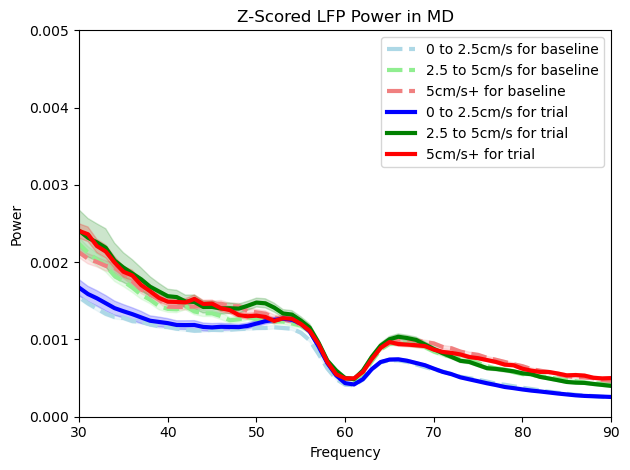

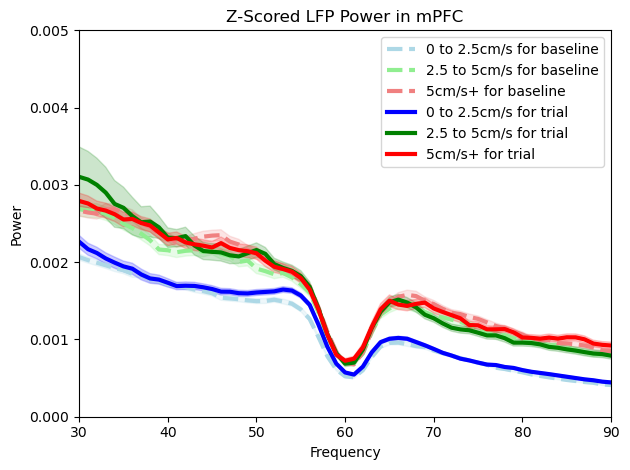

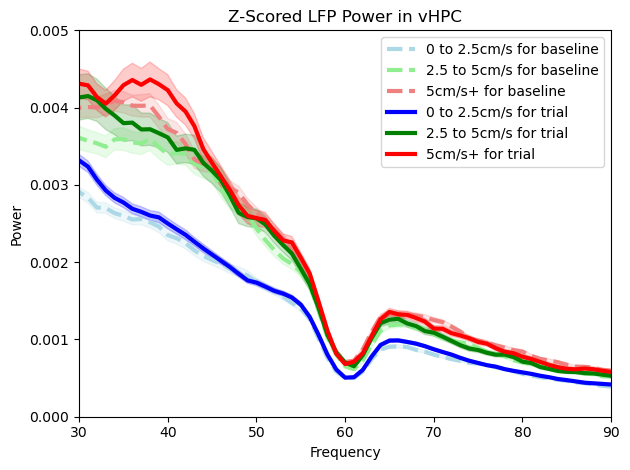

In [91]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.ylim(0, 0.005)

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(bin_to_velocity[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue
    ax.legend()
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsing/region_baselinetrial_velocity/z_scored_lfp_power_freq_{}_to_{}_region_{}.png"\
    .format(low_freq, high_freq, region.split("_")[-1]))


In [60]:
raise ValueError()

ValueError: 

In [ ]:
grouped_all_trials_df = exploded_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_outcome', 'trial_or_baseline', 'binned_current_thorax_velocity']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df = exploded_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_outcome', 'current_subject']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
outcome_to_style = {k: ("dashed" if "baseline" in k else "solid") for k in grouped_all_trials_df["trial_outcome"].unique()}

In [ ]:
outcome_to_style

In [ ]:
num_lines = 3

In [ ]:
# Generate colors from the "Blues" colormap
losing_colors = cm.Oranges(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
winning_colors = cm.Blues(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
rewarded_colors = cm.Greens(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
omission_colors = cm.Reds(np.linspace(0.5, 1, num_lines))

In [ ]:
outcome_to_color = {'lose': losing_colors[2],
 'lose_baseline': losing_colors[0],
 'omission': omission_colors[2],
 'omission_baseline': omission_colors[0],
 'rewarded': rewarded_colors[2],
 'rewarded_baseline': rewarded_colors[0],
 'win': winning_colors[2],
 'win_baseline': winning_colors[0]}

In [ ]:
outcome_to_color = {'lose': "orange",
 'lose_baseline': losing_colors[0],
 'omission': "red",
 'omission_baseline': "hotpink",
 'rewarded': "green",
 'rewarded_baseline': rewarded_colors[0],
 'win': "blue",
 'win_baseline': winning_colors[0]}

In [ ]:
outcome_to_style = {'lose': "solid", 'omission': "dotted", 'rewarded': "dotted", 'win': "solid"}

In [ ]:
outcome_to_style = {'lose': "solid", 'omission': "dashed", 'rewarded': "dashed", 'win': "solid"}

In [ ]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [ ]:
grouped_all_trials_df["trial_outcome"].unique()

In [ ]:
grouped_all_trials_df.head()

# Drawing plots all together

In [ ]:
grouped_all_trials_df["binned_current_thorax_velocity"].unique()

In [ ]:
bin_to_velocity = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [ ]:
bin_to_ylim = {0: 0.15, 1: 0.3, 2: 0.3}

In [ ]:
brain_region_to_ylim = {'spike_interface_BLA': 0.15, 'spike_interface_LH': 0.3, 'spike_interface_MD': 0.3,
       'spike_interface_mPFC': 0.2, 'spike_interface_vHPC': 0.3}

In [ ]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    for velocity in grouped_all_trials_df["binned_current_thorax_velocity"].unique():
        velocity_df = region_df[region_df["binned_current_thorax_velocity"] == velocity]



        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} at {}".format(region, bin_to_velocity[velocity]))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(0, 12)    
        # plt.ylim(0, bin_to_ylim[velocity])
        # plt.yscale("log")
    
        for trial_or_baseline, outcome in itertools.product(velocity_df["trial_or_baseline"].unique(), sorted(velocity_df["trial_outcome"].unique())[::-1]):
            outcome_df = velocity_df[(velocity_df["trial_or_baseline"] == trial_or_baseline) & (velocity_df["trial_outcome"] == outcome)]
            for index, row in outcome_df.iterrows():
                try:
                    # print(row["mean_power"])
                    ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, trial_or_baseline), color=outcome_to_color[outcome], linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                    # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                    plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
                except Exception as e: 
                    print(e)
                    continue
        ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
        plt.tight_layout()
        plt.savefig("./proc/velocity_parsing/z_scored_lfp_power_0_to_12hz_{}_{}.png".format(region, velocity))
        plt.show()
        # # Removing duplicate labels in the legend
        # handles, labels = plt.gca().get_legend_handles_labels()
        # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        # plt.legend(*zip(*unique))

In [ ]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    for velocity in grouped_all_trials_df["binned_current_thorax_velocity"].unique():
        velocity_df = region_df[region_df["binned_current_thorax_velocity"] == velocity]



        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} at {}".format(region, bin_to_velocity[velocity]))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(12, 30)    
        plt.ylim(0, 0.02)
        # plt.yscale("log")
    
        for trial_or_baseline, outcome in itertools.product(velocity_df["trial_or_baseline"].unique(), sorted(velocity_df["trial_outcome"].unique())[::-1]):
            outcome_df = velocity_df[(velocity_df["trial_or_baseline"] == trial_or_baseline) & (velocity_df["trial_outcome"] == outcome)]
            for index, row in outcome_df.iterrows():
                try:
                    # print(row["mean_power"])
                    ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, trial_or_baseline), color=outcome_to_color[outcome], linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                    # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                    plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
                except Exception as e: 
                    print(e)
                    continue
        ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
        plt.tight_layout()
        plt.savefig("./proc/velocity_parsing/z_scored_lfp_power_12hz_to_30hz_{}_{}.png".format(region, velocity))
        plt.show()
        # # Removing duplicate labels in the legend
        # handles, labels = plt.gca().get_legend_handles_labels()
        # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        # plt.legend(*zip(*unique))

In [ ]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    for velocity in grouped_all_trials_df["binned_current_thorax_velocity"].unique():
        velocity_df = region_df[region_df["binned_current_thorax_velocity"] == velocity]



        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} at {}".format(region, bin_to_velocity[velocity]))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(30, 90)    
        plt.ylim(0, 0.005)
        # plt.yscale("log")
    
        for trial_or_baseline, outcome in itertools.product(velocity_df["trial_or_baseline"].unique(), sorted(velocity_df["trial_outcome"].unique())[::-1]):
            outcome_df = velocity_df[(velocity_df["trial_or_baseline"] == trial_or_baseline) & (velocity_df["trial_outcome"] == outcome)]
            for index, row in outcome_df.iterrows():
                try:
                    # print(row["mean_power"])
                    ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, trial_or_baseline), color=outcome_to_color[outcome], linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                    # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                    plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
                except Exception as e: 
                    print(e)
                    continue
        ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
        plt.tight_layout()
        plt.savefig("./proc/velocity_parsing/z_scored_lfp_power_30_to_90hz_{}_{}.png".format(region, velocity))
        plt.show()
        # # Removing duplicate labels in the legend
        # handles, labels = plt.gca().get_legend_handles_labels()
        # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        # plt.legend(*zip(*unique))

In [ ]:
grouped_all_trials_df = exploded_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_or_baseline', 'binned_current_thorax_velocity']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
outcome_df

In [ ]:
bin_to_color = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}


In [ ]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    # plt.ylim(0, bin_to_ylim[velocity])
    # plt.yscale("log")
    for index, row in region_df.iterrows():
        try:
            # print(row["mean_power"])
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} for {}".format(bin_to_velocity[row["binned_current_thorax_velocity"]], row["trial_or_baseline"]), color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]], linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            # ax.lines[0].set_linestyle(outcome_to_style[outcome])
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue
    ax.legend()
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsing/region_baselinetrial_velocity/z_scored_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.ylim(0, 0.015)
    # plt.yscale("log")
    for index, row in region_df.iterrows():
        try:
            # print(row["mean_power"])
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} for {}".format(bin_to_velocity[row["binned_current_thorax_velocity"]], row["trial_or_baseline"]), color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]], linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            # ax.lines[0].set_linestyle(outcome_to_style[outcome])
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue
    ax.legend()
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsing/region_baselinetrial_velocity/z_scored_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.ylim(0, 0.005)
    # plt.yscale("log")
    for index, row in region_df.iterrows():
        try:
            # print(row["mean_power"])
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} for {}".format(bin_to_velocity[row["binned_current_thorax_velocity"]], row["trial_or_baseline"]), color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]], linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            # ax.lines[0].set_linestyle(outcome_to_style[outcome])
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=bin_to_color[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue
    ax.legend()
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsing/region_baselinetrial_velocity/z_scored_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


In [ ]:
raise ValueError()

In [ ]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] <= 1]

In [ ]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'trial_outcome', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
outcome_to_style = {k: ("dashed" if "baseline" in k else "solid") for k in grouped_all_trials_df["trial_outcome"].unique()}

In [ ]:
outcome_to_style

In [ ]:
num_lines = 3

In [ ]:
# Generate colors from the "Blues" colormap
losing_colors = cm.Oranges(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
winning_colors = cm.Blues(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
rewarded_colors = cm.Greens(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
omission_colors = cm.Reds(np.linspace(0.5, 1, num_lines))

In [ ]:
outcome_to_color = {'lose': "orange",
 'lose_baseline': losing_colors[0],
 'omission': "red",
 'omission_baseline': "hotpink",
 'rewarded': "green",
 'rewarded_baseline': rewarded_colors[0],
 'win': "blue",
 'win_baseline': winning_colors[0]}

In [ ]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [ ]:
grouped_all_trials_df["trial_outcome"].unique()

# Drawing plots all together

In [ ]:
brain_region_to_ylim = {'spike_interface_BLA': 0.15, 'spike_interface_LH': 0.3, 'spike_interface_MD': 0.3,
       'spike_interface_mPFC': 0.2, 'spike_interface_vHPC': 0.3}

In [ ]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(0, 12)    

    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                # print(row["mean_power"])
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, trial_or_baseline), color=outcome_to_color[outcome], linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
            except Exception as e: 
                print(e)
                continue
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsing/region_baselinetrial_highlow_velocity/z_scored_lfp_power_0_to_12hz_region_{}_lower_velocity.png".format(region.split("_")[-1]))
    plt.show()


In [ ]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(12, 30)    
    plt.ylim(0, 0.015)
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                # print(row["mean_power"])
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, trial_or_baseline), color=outcome_to_color[outcome], linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
            except Exception as e: 
                print(e)
                continue
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsing/region_baselinetrial_highlow_velocity/z_scored_lfp_power_12_to_30hz_region_{}_lower_velocity.png".format(region.split("_")[-1]))
    plt.show()


In [ ]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(30, 90)    
    plt.ylim(0, 0.005)
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                # print(row["mean_power"])
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, trial_or_baseline), color=outcome_to_color[outcome], linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
            except Exception as e: 
                print(e)
                continue
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsing/region_baselinetrial_highlow_velocity/z_scored_lfp_power_30_to_90hz_region_{}_lower_velocity.png".format(region.split("_")[-1]))
    plt.show()
